In [ ]:
import pandas as pd
import numpy as np

from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer, TransformedTargetRegressor
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LinearRegression,Ridge,Lasso
from sklearn.model_selection import GridSearchCV
from category_encoders import TargetEncoder
from sklearn.model_selection import GridSearchCV


import gc  # Garbage Collector zur Speicherverwaltung
from Preprocessing.preprocessing_pipeline_initial import preprocessing_pipeline
from Preprocessing.preprocessing_pipeline_segment import preprocessing_pipeline_segment
from Preprocessing.split import split_data
from eval_call import evaluate_model


In [5]:
def main_transformed_target_encoding(model, use_gridsearch=False):
    df = preprocessing_pipeline() 
    df = preprocessing_pipeline_segment(df)
    X_train, X_test, y_train, y_test, X, y, categorical_features, numeric_features = split_data(df)

    # Preprocessing-Pipelines erstellen
    # Pipeline für "model" Target Encoding

    numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
    ])
    model_transformer = Pipeline(steps=[
        ('imputer', SimpleImputer(strategy='most_frequent')),
        ('target_encoder', TargetEncoder())
    ])

    # Pipeline für alle anderen kategorischen Features
    categorical_other_transformer = Pipeline(steps=[
        ('imputer', SimpleImputer(strategy='most_frequent')),
        ('onehot', OneHotEncoder(handle_unknown='ignore'))
    ])

    # Gesamt-Preprocessor
    preprocessor = ColumnTransformer(transformers=[
        ('num', numeric_transformer, numeric_features),
        ('model_target', model_transformer, ['model']),
        ('cat', categorical_other_transformer, ['brand', 'color', 'transmission_type', 'fuel_type', 'segment'])
    ])

    # Modell + Transformation
    transformed_model = TransformedTargetRegressor(
        regressor=model,
        func=np.log1p,
        inverse_func=np.expm1
    )

    # Pipeline aufbauen
    linear_regression_pipeline = Pipeline(steps=[
        ('preprocessor', preprocessor),
        ('model', transformed_model)
    ])

    if use_gridsearch:
        # Grid Search Setup
        from sklearn.model_selection import GridSearchCV

        param_grid = {
            'model__regressor__alpha': np.logspace(-3, 3, 30)
        }

        grid_search = GridSearchCV(
            linear_regression_pipeline,
            param_grid,
            cv=5,
            scoring='neg_root_mean_squared_error',
            n_jobs=-1,
            verbose=2
        )

        print("Starte Grid Search...")
        grid_search.fit(X_train, y_train)
        

        best_pipeline = grid_search.best_estimator_
        print("Bestes Alpha:", grid_search.best_params_)

        y_pred = best_pipeline.predict(X_test)
        evaluate_model(y_test, y_pred, "Ridge Regression mit GridSearch")
    
    else:
        # Normales Training ohne GridSearch
        print("Trainiere Modell ohne GridSearch...")
        linear_regression_pipeline.fit(X_train, y_train)
        y_pred = linear_regression_pipeline.predict(X_test)
        evaluate_model(y_test, y_pred, "Linear Regression (ohne GridSearch)")
 

In [13]:
def load_and_split_data(drop_cols = None, segment = None, stratify_on = 'model'):
    '''lädt und splittet die Daten'''
    print('-'*30)
    print('Load and splitting of data started...')
    df = preprocessing_pipeline() 

    if segment: 
        df = preprocessing_pipeline_segment(df)
        print('Segment has been added to df')
        
    if drop_cols:
        df = df.drop(drop_cols, axis = 1)
        print(f'{drop_cols} dropped')
    print('data has been loaded and splitted')
    return split_data(df, stratify_on)
    
def build_preprocessor(numeric_features,categorical_features):
    """Baut den Preprocessor für die Pipeline"""
    print('-'*30)
    print('Starting to build Preprocesser...')
    numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
    ])
    
    categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
    ])

    preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)
    ])
    print('Preprocesser built')
    return preprocessor

def build_regression_pipeline(preprocessor, model,use_log_transform = True):
    """Baut die Pipeline."""
    print('-'*30)
    if use_log_transform:
        # Wickle das Modell in TransformedTargetRegressor ein
        final_model_step = TransformedTargetRegressor(
            regressor=model,
            func=np.log1p,
            inverse_func=np.expm1
        )
        print(f"Building pipeline with {type(model).__name__} and Log-Transform for y.")
    else:
        # Verwende das Modell direkt
        final_model_step = model
        print(f"Building pipeline with {type(model).__name__} and NO Log-Transform for y.")

    pipeline = Pipeline(steps=[
        ('preprocessor', preprocessor),
        ('model', final_model_step)
    ])
    return pipeline

def train_evaluate_pipeline(pipeline,  X_train, X_test, y_train, y_test, model_name):
    """Trainiert die Pipeline, macht Vorhersagen und evaluiert."""
    print('-'*30)
    print(f"Training {model_name}...")
    pipeline.fit(X_train, y_train)
    print("Training complete.")
    print(f"Predicting with {model_name}...")
    y_pred = pipeline.predict(X_test)
    print("Prediction complete.")
    print('-'*30)
    return evaluate_model(y_test, y_pred, model_name)
    

In [ ]:
def main(col_drop,model,stratify_col = 'model',segment = None,use_log = True, use_gridsearch = False):
    X_train, X_test, y_train, y_test, X, y, categorical_features, numeric_features = load_and_split_data(drop_cols= col_drop, segment= segment, stratify_on= stratify_col)
    preprocessor = build_preprocessor(numeric_features,categorical_features)
    pipeline = build_regression_pipeline(preprocessor, model, use_log_transform = use_log)
    return train_evaluate_pipeline(pipeline, X_train, X_test, y_train, y_test, model)


In [44]:
main(col_drop= None, stratify_col='model', model = Ridge(alpha=8.53), use_log= False)

------------------------------
Load and splitting of data started...
data has been loaded and splitted
------------------------------
Starting to build Preprocesser...
Preprocesser built
------------------------------
Building pipeline with Ridge and NO Log-Transform for y.
------------------------------
Training Ridge(alpha=8.53)...
Training complete.
Predicting with Ridge(alpha=8.53)...
Prediction complete.
------------------------------
Ridge(alpha=8.53) Performance Metrics:
MAE: 5109.31
MSE: 142239222.76
RMSE: 11926.41
R²: 0.72
------------------------------


In [22]:
main(col_drop= None, stratify_col='model', model = Ridge(alpha=8.53), use_log= True)

------------------------------
Load and splitting of data started...
data has been loaded and splitted
------------------------------
Starting to build Preprocesser...
Preprocesser built
------------------------------
Building pipeline with Ridge and Log-Transform for y.
------------------------------
Training Ridge(alpha=8.53)...
Training complete.
Predicting with Ridge(alpha=8.53)...
Prediction complete.
------------------------------
Ridge(alpha=8.53) Performance Metrics:
MAE: 4501.66
MSE: 114905132.21
RMSE: 10719.38
R²: 0.77
------------------------------


In [127]:
X_train, X_test, y_train, y_test, X, y, categorical_features, numeric_features = load_and_split_data(stratify_on='model')
preprocessor = build_preprocessor(numeric_features,categorical_features)
pipeline = build_regression_pipeline(preprocessor, model = Ridge(alpha=8.53), use_log_transform = True)

------------------------------
Load and splitting of data started...
data has been loaded and splitted
------------------------------
Starting to build Preprocesser...
Preprocesser built
------------------------------
Building pipeline with Ridge and Log-Transform for y.


In [128]:
pipeline.fit(X_train,y_train)
y_pred_train = pipeline.predict(X_train)

In [129]:
X_train_df = pd.DataFrame(X_train)

y_train_series = pd.Series(y_train, name='y_true')  
y_pred_series = pd.Series(y_pred_train, name='y_pred')

df = pd.concat([X_train_df.reset_index(drop=True),
                      y_train_series.reset_index(drop=True),
                      y_pred_series.reset_index(drop=True)], axis=1)

In [130]:
df['residual'] = round(df['y_true'] - df['y_pred'],2)

In [131]:
df.sort_values(by= 'residual', ascending= False).head(10)

,brand,model,color,power_ps,transmission_type,fuel_type,fuel_consumption_l_100km,fuel_consumption_g_km,mileage_in_km,registration_month,registration_year,y_true,y_pred,residual
20517,porsche,Porsche 991,white,430.0,Automatic,Petrol,8.9,207.0,27000.0,1,2015,1350000,151571.658062,1198428.34
88697,audi,Audi Q7,black,245.0,Automatic,Diesel,7.4,195.0,143700.0,11,2011,1000000,28421.250942,971578.75
95656,bmw,BMW 550,brown,400.0,Automatic,Diesel,6.3,165.0,87000.0,7,2018,1010101,48960.429721,961140.57
50236,mercedes-benz,Mercedes-Benz G 63 AMG,green,585.0,Automatic,Petrol,13.1,456.0,6000.0,1,2023,525000,123215.345132,401784.65
27763,porsche,Porsche 997,black,408.0,Automatic,Petrol,10.2,240.0,39000.0,3,2011,489356,119316.747677,370039.25
22478,mercedes-benz,Mercedes-Benz G 63 AMG,black,585.0,Automatic,Petrol,20.1,456.0,15.0,6,2023,397999,110587.479544,287411.52
3895,mercedes-benz,Mercedes-Benz G 63 AMG,green,585.0,Automatic,Petrol,20.1,456.0,13.0,1,2023,403291,120249.030569,283041.97
7542,mercedes-benz,Mercedes-Benz G 63 AMG,red,585.0,Automatic,Petrol,20.1,456.0,99.0,11,2022,398500,117629.386774,280870.61
70580,porsche,Porsche 991,silver,510.0,Manual,Petrol,13.8,317.0,1500.0,9,2019,399000,119909.483951,279090.52
29053,mercedes-benz,Mercedes-Benz G 63 AMG,green,585.0,Automatic,Petrol,14.4,456.0,199.0,10,2022,386500,125908.033195,260591.97


In [146]:
df.query('residual >= 50000')

,brand,model,color,power_ps,transmission_type,fuel_type,fuel_consumption_l_100km,fuel_consumption_g_km,mileage_in_km,registration_month,registration_year,y_true,y_pred,residual
155,porsche,Porsche 991,blue,500.0,Automatic,Petrol,12.7,296.0,6800.0,6,2016,234900,150357.163700,84542.84
559,porsche,Porsche 992,silver,510.0,Automatic,Petrol,12.9,293.0,3200.0,5,2022,227490,161893.322715,65596.68
1337,mercedes-benz,Mercedes-Benz AMG GT,orange,730.0,Automatic,Petrol,9.4,292.0,400.0,5,2022,488500,338929.617722,149570.38
1851,mercedes-benz,Mercedes-Benz A 250,red,211.0,Automatic,Petrol,6.0,142.0,163350.0,3,2014,89990,17110.335698,72879.66
2500,porsche,Porsche Cayman,black,299.0,Automatic,Petrol,6.9,158.0,17500.0,9,2017,142991,85706.481652,57284.52
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
131111,porsche,Porsche 991,silver,500.0,Manual,Petrol,12.9,290.0,14182.0,3,2018,169990,119935.860324,50054.14
131197,porsche,Porsche Cayenne,silver,385.0,Automatic,Diesel,8.2,215.0,175900.0,4,2016,201911,38644.463761,163266.54
132314,porsche,Porsche 991,grey,521.0,Automatic,Petrol,12.8,291.0,4991.0,7,2018,269991,176309.671843,93681.33
132931,porsche,Porsche Macan,black,258.0,Automatic,Diesel,6.3,167.0,71566.0,5,2016,107600,52078.342189,55521.66


In [132]:
import seaborn as sns
import matplotlib.pyplot as plt

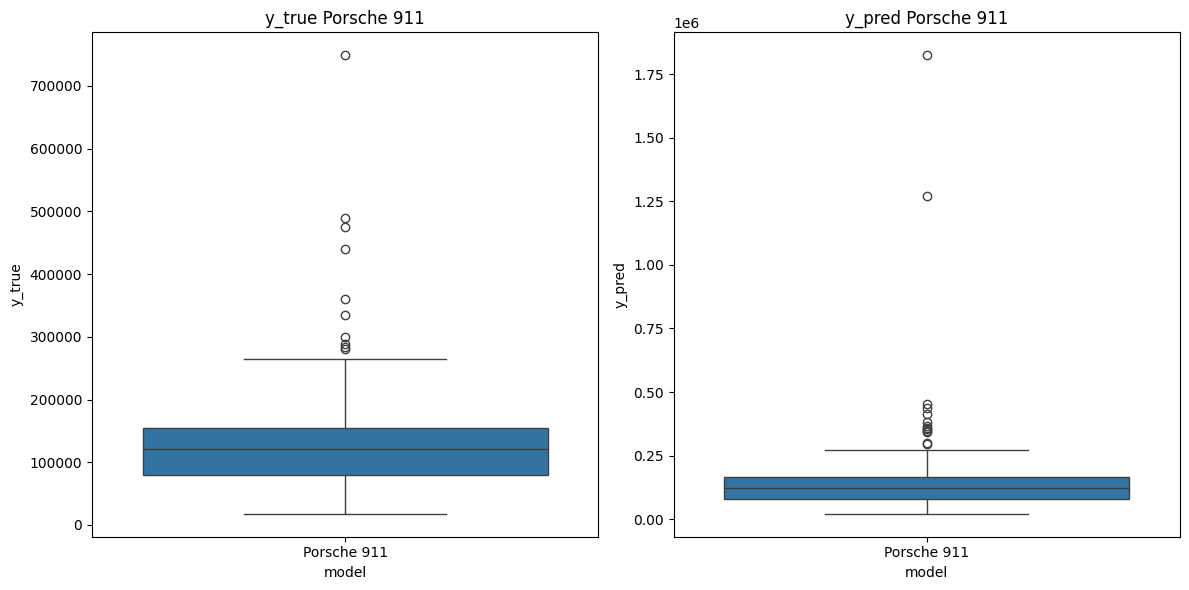

In [133]:
fig, axes = plt.subplots(1, 2, figsize=(12, 6))  # 1 Zeile, 2 Spalten

sns.boxplot(data=df[df['model'] == 'Porsche 911'], x='model', y='y_true', ax=axes[0])
axes[0].set_title('y_true Porsche 911')

sns.boxplot(data=df[df['model'] == 'Porsche 911'], x='model', y='y_pred', ax=axes[1])
axes[1].set_title('y_pred Porsche 911')

plt.tight_layout()
plt.show()

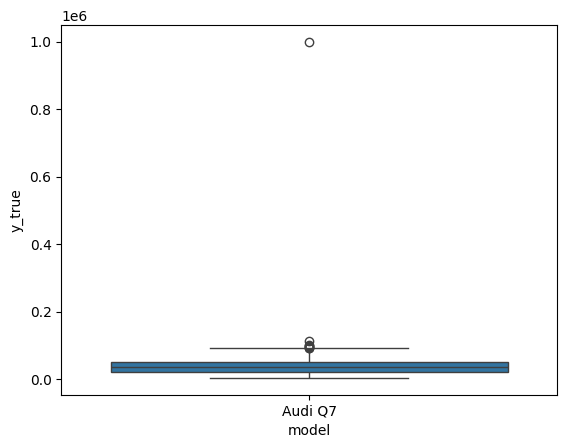

In [134]:
sns.boxplot(data=df[df['model'] == 'Audi Q7'], x= 'model', y = 'y_true')
plt.show()

In [135]:
Q1 = df['residual'].quantile(0.25)
Q3 = df['residual'].quantile(0.75)
IQR = Q3 - Q1

outlier_threshold = Q3 + 1.5 * IQR

print(f"IQR-basierte Outlier-Schwelle für absolute Residuen: {outlier_threshold:.2f}")

outliers_df_iqr = df[df['residual'] > outlier_threshold]

print(f"Anzahl gefundener Outlier (IQR-Methode): {len(outliers_df_iqr)}")

IQR-basierte Outlier-Schwelle für absolute Residuen: 10374.17
Anzahl gefundener Outlier (IQR-Methode): 6620


In [136]:
outliers_df_iqr.sort_values(by = 'model')

,brand,model,color,power_ps,transmission_type,fuel_type,fuel_consumption_l_100km,fuel_consumption_g_km,mileage_in_km,registration_month,registration_year,y_true,y_pred,residual
36517,alfa-romeo,Alfa Romeo Giulia,white,280.0,Automatic,Petrol,8.1,184.0,9999.0,10,2022,59690,45295.975008,14394.02
102199,alfa-romeo,Alfa Romeo Giulia,white,280.0,Automatic,Petrol,8.1,184.0,10.0,11,2022,59990,47890.234195,12099.77
1233,alfa-romeo,Alfa Romeo Giulia,black,200.0,Automatic,Petrol,7.5,170.0,5.0,2,2023,47404,33684.256894,13719.74
89614,alfa-romeo,Alfa Romeo Giulia,black,200.0,Automatic,Petrol,7.5,170.0,5.0,2,2023,47400,33684.256894,13715.74
35365,alfa-romeo,Alfa Romeo Giulia,silver,200.0,Automatic,Petrol,6.8,156.0,6575.0,2,2022,45490,33071.451470,12418.55
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
119116,smart,smart forTwo,grey,109.0,Automatic,Petrol,4.6,104.0,47938.0,4,2018,26899,13238.176894,13660.82
86822,smart,smart forTwo,white,102.0,Automatic,Petrol,5.2,123.0,49200.0,3,2014,28990,11967.795359,17022.20
102058,smart,smart forTwo,silver,109.0,Automatic,Petrol,4.6,104.0,32941.0,2,2018,29990,13501.555456,16488.44
84925,smart,smart forTwo,white,102.0,Automatic,Petrol,5.2,119.0,5500.0,3,2015,32498,15521.151735,16976.85


In [173]:
residuals = y_train - y_pred_train
#outlier_mask = (residuals < (Q1 - 1.5 * IQR)) | (residuals > (Q3 + 1.5 * IQR))
outlier_mask = residuals >= 100000

In [175]:
X_train_clean = X_train.loc[~outlier_mask]
y_train_clean = y_train[~outlier_mask]

In [176]:
pipeline.fit(X_train_clean, y_train_clean)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  ['power_ps',
                                                   'fuel_consumption_l_100km',
                                                   'fuel_consumption_g_km',
                                                   'mileage_in_km']),
                                                 ('cat',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('onehot',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  ['brand', 'model', 'color',
                                                   'transmission_type',
                                                   'fuel_type'])])),
                ('model',
                 TransformedTargetRegressor(func=<ufunc 'log1p'>,
                                            inverse_func=<ufunc 'expm1'>,
                                            regressor=Ridge(alpha=8.53)))])

In [177]:
y_pred = pipeline.predict(X_test)
evaluate_model(y_test, y_pred, 'LinearRegression')

LinearRegression Performance Metrics:
MAE: 4499.48
MSE: 115710661.82
RMSE: 10756.89
R²: 0.77
------------------------------
